dataframe: (1199, 5)
      0    1       2    3    4
0  5831  0.0  0.00.1  0.0  0.1
1  5841  0.0     0.0  0.0  0.0
2  5852  0.0     0.0  0.0  0.0
3  5862  0.0     0.0  0.0  0.0
4  5871  0.0     0.0  0.0  0.0


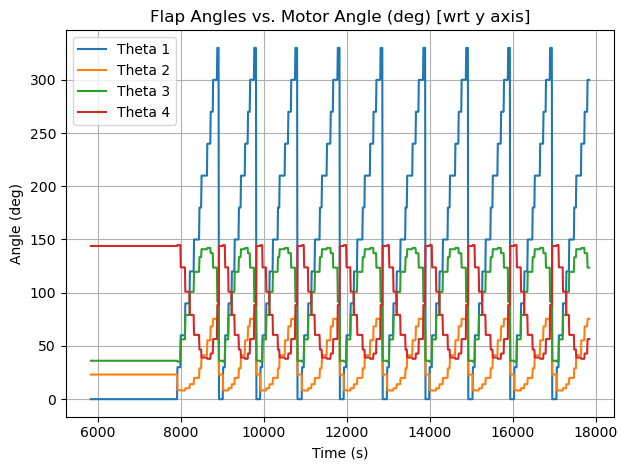

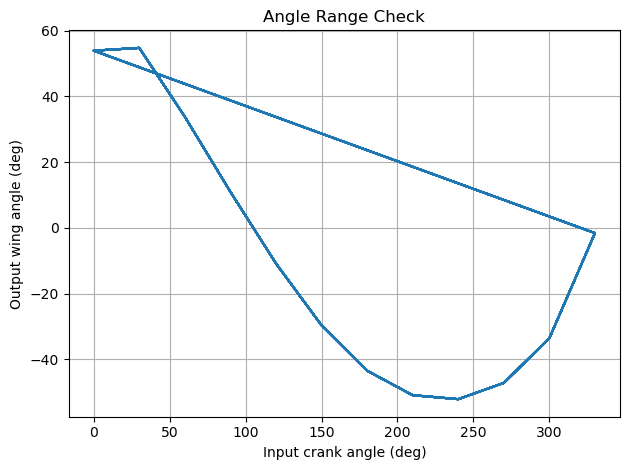

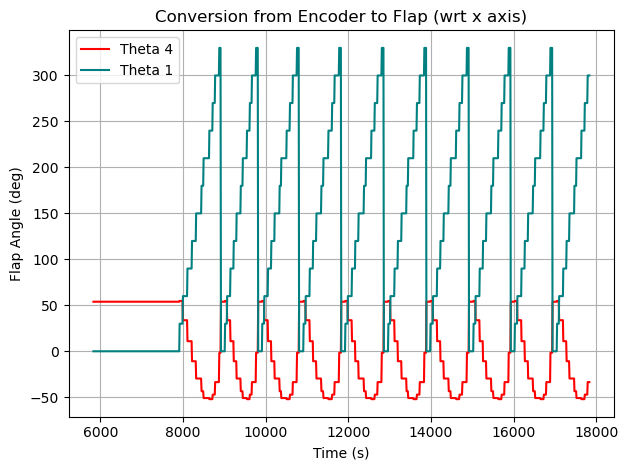

[-53.90445697 -53.90445697 -53.90445697 ...  33.53949688  33.53949688
  33.53949688]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve

# link lengths (mm)
L1 = 5.5  # input
L2 = 11.55  # coupler
L3 = 7.70  # output
L4 = 9.90  # fixed base

# pull data from file and store it
#key:  (time, right crank angle, left crank angle, pwr A, pwr B)
#data = np.loadtxt('robot_log.txt', delimiter='\t', usecols=(0, 1, 2))  # ignore trailing commas (I messed up in my original print function)
#data=pd.read_csv("robot_log.txt", delimiter=",")
data=pd.read_csv("robot_log_7_16.txt", sep=r"\s+", header=None)

# extract each variable column
time = data.iloc[:, 0].to_numpy()
right_theta_deg = data.iloc[:, 1].to_numpy()
left_theta_deg = data.iloc[:, 2].to_numpy()

# pick a wing here (sub left for left trial)
encoder_all = right_theta_deg 

#conversion to properly limited units
theta1_all = np.deg2rad(encoder_all)  # rest of code assumes rads
theta1_wrapped=np.mod(theta1_all, 2*np.pi)
theta1_deg_wrap=np.mod(encoder_all, 360)

print("dataframe:",data.shape)
print(data.head())

# storage for outputs
theta2_output = []
theta3_output = []
theta4_output= []
theta4_y = []

#guessing a starting value for values of theta 2 and 3 
initial_guess=[np.radians(60), np.radians(30)]

#write key functions from calculations
def sys_equations(unknowns, theta1_wrapped,L1,L2,L3,L4):
    theta2, theta3= unknowns
    equation1=L1*np.cos(theta1_wrapped)+L2*np.cos(theta2)-L3*np.cos(theta3)-L4
    equation2=L1*np.sin(theta1_wrapped)+L2*np.sin(theta2)-L3*np.sin(theta3)
    return[equation1,equation2]

# loop through each input angle and find the unknowns
for t1 in theta1_all:
        #fsolve is (func, x0, args) 
        solution=fsolve(sys_equations, initial_guess, args=(t1,L1,L2,L3,L4))
        theta2, theta3=solution
        #final output flap angle wrt x and y axis
        theta4=np.radians(90)-theta3 
        theta4_yaxis=np.radians(180)-theta3
        theta2_output.append(theta2)
        theta3_output.append(theta3)
        theta4_output.append(theta4)
        theta4_y.append(theta4_yaxis)
        
        #continuously update to test other values
        initial_guess=solution
        
#test value to make sure loading from file
#print("Theta2 (first 5):", theta2_output[:5])

#plot in radians

#plt.figure(1)
#plt.plot(time, theta1_wrapped, label='Theta 1')
#plt.plot(time, theta2_output, label='Theta 2')
#plt.plot(time, theta3_output, label='Theta 3')
#plt.plot(time, theta4_output, label='Theta 4')
#plt.xlabel('Time (s)')
#plt.ylabel('Angle (rad)')
#plt.title('Four-Bar Linkage Output Angles vs. Input Angle(rad)')
#plt.legend()
#plt.grid(True)
#plt.tight_layout()
#plt.show()


#conversion back to original degrees to check graph (has to be after trig)
deg_theta1= theta1_deg_wrap
deg_theta2=np.rad2deg(theta2_output)
deg_theta3=np.rad2deg(theta3_output)
deg_theta4=np.rad2deg(theta4_output)
deg_theta4_y=np.rad2deg(theta4_y)

plt.figure(2)
plt.plot(time, deg_theta1, label='Theta 1')
plt.plot(time, deg_theta2, label='Theta 2')
plt.plot(time, deg_theta3, label='Theta 3')
plt.plot(time, deg_theta4_y, label='Theta 4')
plt.xlabel('Time (s)')
plt.ylabel('Angle (deg)')
plt.title('Flap Angles vs. Motor Angle (deg) [wrt y axis]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# angle range check plot
plt.plot(deg_theta1, deg_theta4)
plt.xlabel('Input crank angle (deg)')
plt.ylabel('Output wing angle (deg)')
plt.title('Angle Range Check')
plt.grid(True)
plt.tight_layout()
plt.show()

#output plot
plt.figure(3)
plt.plot(time, deg_theta4, label='Theta 4', color= 'red')
plt.plot(time, deg_theta1, label='Theta 1', color= 'teal')
plt.xlabel('Time (s)')
plt.ylabel('Flap Angle (deg)')
plt.title('Conversion from Encoder to Flap (wrt x axis)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

print(-deg_theta4)

#export raw and calculated to csv file (KEY: time in ms, output angle in deg)
df_raw=pd.DataFrame({
    0:time,
    1:right_theta_deg,
    2:left_theta_deg
})

df = pd.DataFrame({
    0: time,
    1: deg_theta4,
})



# save to CSV without index and header (matlab-fix)
df_raw.to_csv("both_raw_encoders.csv", index=False, header=False)
df.to_csv("flap_output_right.txt", index=False, header=False)




In [26]:
import pandas as pd

df = pd.read_csv('both_raw_encoders.csv')  # load CSV
df.to_csv('both_raw_encoders.txt', index=False)  # save as TXT with commas
